# Import Packages

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset

import numpy as np
import numpy.ma as ma

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

# Define Functions

In [2]:
# function to display a map
def Display_map(lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data,title_png,title_to_adapt,label,parallels,meridians):#,projects):

    lon_moz, lat_moz = np.meshgrid(lon, lat) # this is necessary to have a map
    
    # create Map
    fig = plt.figure()
    plt.title(title_to_adapt) # title of the map # automatized with year
    map = Basemap(projection ='merc',llcrnrlon=lon_min_wanted+5,llcrnrlat=lat_min_wanted+2,urcrnrlon=lon_max_wanted-5,urcrnrlat=lat_max_wanted-2,resolution='i', epsg = 4326) # projection, lat/lon extents an
    # adding and substracting a quantity to the lon and lat to have a bit of margin when presenting it
    # substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90
    map.drawcountries()
    map.drawcoastlines()
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    temp = map.contourf(lon_moz,lat_moz,data)
    #projects.plot(ax=ax) # project in projection EPSG:4326
    cb = map.colorbar(temp,"right", size="5%", pad="2%") # color scale, second parameter can be locationNone or {'left', 'right', 'top', 'bottom'}
    cb.set_label(label) # name for color scale
    plt.savefig(os.path.join(out_path,'figures',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
    plt.show()

In [3]:
# function to extract the name of the file from its url
# the imput is an url
def extract_name_file(url):
    index_before_name=url.rfind('/') # returns the highest index where the last character '/' was found, which is just before the name of the file    
    name = url[index_before_name+1:len(url)] # return the name of the file as a string, with the suffix '.nc'
    return name

# function 'produce_name_list' produce a list of files' name, with the suffix '.nc'
# 'produce_name_list' use the function 'extract_name_file' to have the name of a file from its url
# the input is a list of url, from which we want to extract the corresponding names of files
def produce_name_list(url_list):
    name_list=[] # create empty list
    for file in url_list:
        f_name = extract_name_file(file) # return the name of the file as a string, with the suffix '.nc'
        name_list.append(f_name) # add extracted name in the list
    return name_list # return the list of names in the url_list

In [4]:
# function download_file download the file in the url given as input
# the input is an url of a file
def download_file(file):
    # find the name of the file
    f_name = extract_name_file(file) # return the name of the file as a string, with the suffix '.nc' at the end of the name
    # check if the file was already downloaded
    #test = os.path.join('//COWI.net/projects/A245000/A248363/CRVA/Datasets/NEX-GDDP-CMIP6/',f_name+'.nc')
    #if os.path.isfile(test): # if the file was aleready download
        #continue # continue the for loop without executing the code after this line. The code follonwing download the file
    #    return# if we entered the if, the file was already dowloaded, no need to downloaded it again
    # the file was not downloaded, the following code will permit to download it in the servor for dataset
    r = requests.get(file) # return the url were data need to be downloaded
    # download data in the servor for datasets
    with open(f'//COWI.net/projects/A245000/A248363/CRVA/Datasets/NEX-GDDP-CMIP6/{f_name}', 'wb') as f:
        f.write(r.content)
    return file
#results = ThreadPool(NBCORES).imap_unordered(download_file, url_list_precipitation)
#for r in results: #I don't understand why, ut without this step it does not work
#     print(r)

In [5]:
#### Former version of download_file function
# download only precipitation files
r'''
for file in url_list_precipitation: # for loop to download the file in each url
    # check if the file was already downloaded
    #test = os.path.join('//COWI.net/projects/A245000/A248363/CRVA/Datasets/NEX-GDDP-CMIP6/',f_name+'.nc')
    #if os.path.isfile(test): # if the file was aleready download
        #continue # continue the for loop without executing the code after this line. The code follonwing download the file
        # if we entered the if, the file was already dowloaded, no need to downloaded it again
    # the file was not downloaded, the following code will permit to download it in the servor for dataset
    download_file(file)
'''

"\nfor file in url_list_precipitation: # for loop to download the file in each url\n    # check if the file was already downloaded\n    #test = os.path.join('//COWI.net/projects/A245000/A248363/CRVA/Datasets/NEX-GDDP-CMIP6/',f_name+'.nc')\n    #if os.path.isfile(test): # if the file was aleready download\n        #continue # continue the for loop without executing the code after this line. The code follonwing download the file\n        # if we entered the if, the file was already dowloaded, no need to downloaded it again\n    # the file was not downloaded, the following code will permit to download it in the servor for dataset\n    download_file(file)\n"

In [6]:
# function 'list_name_corrupted_file' aims to return a list of names, corresponding to the names of the corrupted files
# in the name_list given as input
def list_name_corrupted_file(name_list):
    ## Hypothesis: some files are corrupted
    # check if files are corrupted and count the corrupted ones
    invalid_files = [] # create an empty list to register the names of the corrupted files
    for name in name_list:
        if not name.endswith('.nc'):
            name = name + '.nc'
        try:
            path=os.path.join(out_path,name)
            im = Dataset(path)
        except (IOError, OSError):
            # the files is corrupted
            invalid_files.append(name) # register name of the corrupted files
    return invalid_files # return the name with suffix '.nc' of corrupted files

In [7]:
# list urls that should be downloaded again
def url_to_download_again(url_list,invalid_files):
    url_corrupted_file = []
    for url in url_list:
        f_name = extract_name_file(url) # return the name of the file as a string
        if f_name in invalid_files:
            url_corrupted_file.append(url)

    dict ={' fileUrl':url_corrupted_file}
    df = pd.DataFrame(dict)
    path = os.path.join(out_path,'file_to_download_again.csv')
    df.to_csv(path)
    return url_corrupted_file

In [8]:
## those three function are used to have the information concerning a file
## information are in the name of the file, so the name of the file is used to find its related information
## information mean variable, time_aggregation, model, scenario, year of the file

### this function permit to extract the word before the first character '_' in the input 'name'
### the input name is in format str
### returning the new_name, without the word found, will permit to re-use the function to find all 
#     the information concerning the studied file
def name_next_boundary(name):
    index_before_name=name.find('_') # returns the lowest index where the character '_' was found
    word = name[0:index_before_name] # first word in the string 'name', before the first character '_'
    new_name = name.replace(word+'_','') # delete the word found from the string 'name'
    return word, new_name # return, in string format, the word found (which is an information of the studied file), 
                    # and the string 'new_name', which is 'name' without the word found

# this function permit to extract the year of the studied file
# the year is always writen at the end of the name's file
# the input name is in format str
def find_year(name):
    index_before_name=name.rfind('_') # returns the highest index where the character '_' was found
    # the last character '_' is just before the year in the string 'name'
    # determine if the string 'name' ends with '.nc'
    if name.endswith('.nc'):
        # 'name' ends with '.nc'
        name_end = 3 # the three last character of the string name will be removed to find the year of the studied file
    else:
        # 'name' does not end with '.nc'
        name_end = 0 # no character will be removed at the end of 'name' to find the year of the studied file
    year = name[index_before_name+1:len(name)-name_end] # the year is extracted from the name of the file studied
    # based on the index_before_name (highest index where the character '_' was found) and the suffix of 'name'
    return year # the year in string format is returned

# This function use the functions 'name_next_boundary' and 'find_year' to extract the information of the file studied
# the input name is in format str, the name of the file from which we want information
def data_information(name):
    #### use of the function 'name_next_boundary': each time it is used, 
    # returns an information, and the name of the studied file without this information
    (variable, shorten_name) = name_next_boundary(name)
    (time_aggregation, shorten_name) = name_next_boundary(shorten_name)
    (model, shorten_name) = name_next_boundary(shorten_name)
    (scenario, shorten_name) = name_next_boundary(shorten_name)
    #### use the function 'find_year' to extract the information 'year' from the string 'shorten_name'
    year = find_year(shorten_name)
    # the function returns all the information of the studied file
    return variable, time_aggregation, model, scenario, year

# Projects information

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_31872\555398840.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


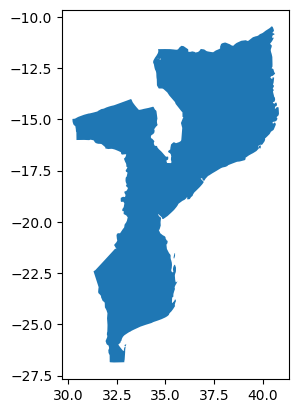

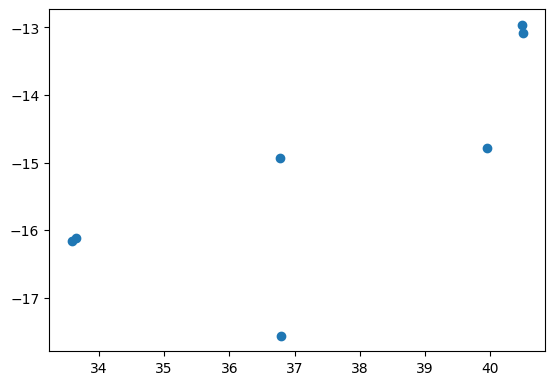

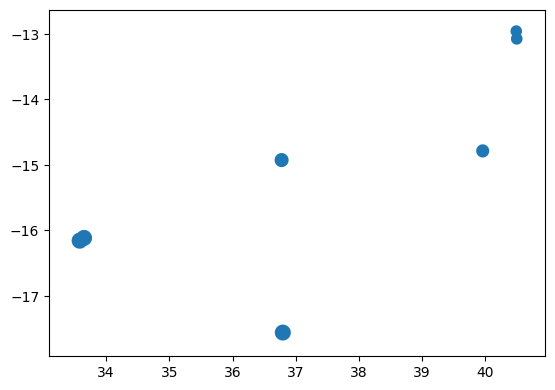

In [9]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 1
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

# Define Paths

In [10]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Infos for Multiprocessing

In [11]:
# count the number of CPU/cores
mp.cpu_count()

8

In [12]:
NBCORES=5

# Complete list of url with files to download

In [13]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [14]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

# Interest in precipitation files
Define list of url and files' names corresponding to precipitation files between 2021 and 2060

In [15]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061]

In [16]:
len(url_list_precipitation)

5160

In [17]:
name_list_precipitation = produce_name_list(url_list_precipitation)

In [ ]:
name_list_precipitation

# List of corrupted files to download again

In [ ]:
name_list_precipitation_corrupted = list_name_corrupted_file(name_list_precipitation)
url_corrupted_file=url_to_download_again(url_list_precipitation,name_list_precipitation_corrupted)
len(name_list_precipitation_corrupted)

In [ ]:
name_list_precipitation_corrupted

# Download file of interest

In [ ]:
# try download again corrupted files
results = ThreadPool(NBCORES).imap_unordered(download_file, url_corrupted_file) 
# first input is the function, second input must be an iterable
for r in results: #I don't understand why, without this step, it does not work
     print(r)

In [ ]:
# same aim as cell before, but performing without ThreadPool
for file in url_corrupted_file: # for loop to download the file in each url
    # check if the file was already downloaded
    #test = os.path.join('//COWI.net/projects/A245000/A248363/CRVA/Datasets/NEX-GDDP-CMIP6/',f_name+'.nc')
    #if os.path.isfile(test): # if the file was aleready download
        #continue # continue the for loop without executing the code after this line. The code follonwing download the file
        # if we entered the if, the file was already dowloaded, no need to downloaded it again
    # the file was not downloaded, the following code will permit to download it in the servor for dataset
    download_file(file)

In [ ]:
while len(url_corrupted_file) != 0: # while the list 'url_corrupted_file' is not empty, the following code will continue
    for file in url_corrupted_file: # for loop to download the file in each url
        download_file(file)
    name_list_precipitation_corrupted = list_name_corrupted_file(name_list_precipitation)
    url_corrupted_file=url_to_download_again(url_list_precipitation,name_list_precipitation_corrupted) 

# Check if download files are corrupted or not

In [ ]:
name_list_precipitation_corrupted = list_name_corrupted_file(name_list_precipitation)
url_corrupted_file=url_to_download_again(url_list_precipitation,name_list_precipitation_corrupted)
len(name_list_precipitation_corrupted)

In [ ]:
name = 'pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2035.nc'
path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2035.nc'
Dataset(path)

###### Basics to read nc files

In [ ]:
## read data, _FillValue should be NaN
solar_1950=Dataset(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc')
r'''
hurs=solar_1950.variables['hurs']
hurs
hurs._FillValue
solar_dataframe = np.ma.getdata(solar_1950.variables['hurs']).data
solar_dataframe
len(solar_dataframe[solar_dataframe!=1.e+20])
len(solar_dataframe[solar_dataframe==1.e+20])
type(solar_dataframe)
solar_dataframe.size
solar_dataframe.size-len(solar_dataframe[solar_dataframe!=1.e+20])-len(solar_dataframe[solar_dataframe==1.e+20])
'''

In [ ]:
solar_dataframe=np.ma.getdata(pr_2052.variables['pr']).data
len(solar_dataframe[solar_dataframe!=1.e+20])

In [ ]:
len(solar_dataframe[solar_dataframe==1.e+20])

# Produce csv files with data to use

In [ ]:
name=non_corrupted_file_pr[0]
name.replace('.nc','')
(variable, time_aggregation, model, scenario, year) = data_information(name)

In [ ]:
variable

In [ ]:
year

In [ ]:
name

In [ ]:
[area_projects[0][0],area_projects[1][0],area_projects[2][0],area_projects[3][0]]

In [ ]:
from FunctionsAndClass import register_data
from FunctionsAndClass import dataframe_copernicus

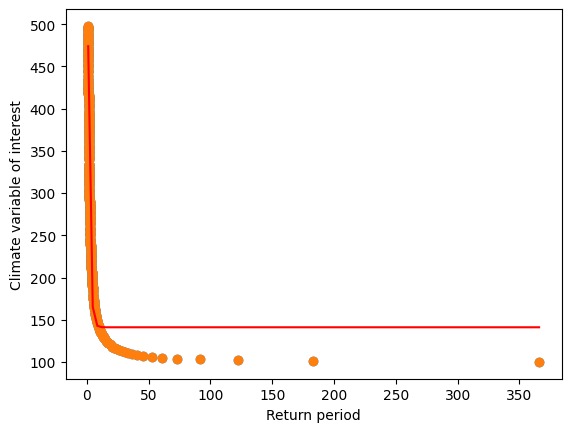

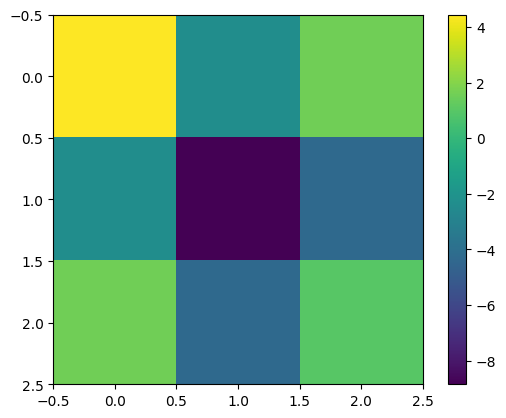

In [22]:
from FunctionsAndClass import year_copernicus

In [23]:
(year, year_str, index_dates) = year_copernicus(2021,2060)

In [24]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name)
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [25]:
scenarios

['ssp245', 'ssp585', 'ssp126', 'ssp370']

In [28]:
name_list_precipitation.find()

AttributeError: 'list' object has no attribute 'find'

In [ ]:
create_dataframe('daily',year_str,scenarios,models,out_path, name_variable, projects['Name'],area,period,index_dates,dates,path_for_csv,title_file,source):    